In [8]:
# Imports

from OverwatchProcessData import get_vector_herostats
from OverwatchProcessData import get_competitive_rank, hero_stats
from OverwatchGatherData import Player, find_usernames

import numpy as np
import os

np.random.seed(3)

from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [9]:
# Loading Data

specific_stats = {}

for stat in hero_stats:
    
    hero, _, _ = stat.split(" ")
    
    if hero in specific_stats:
        
        specific_stats[hero].append(stat)
    
    else:
        
        specific_stats[hero] = [stat]

def generate_players():
    
    for filename in os.listdir('profiles'):
        
        player = Player.from_file(os.path.join('profiles', filename))
        
        if 'error' not in player.json:
            
            yield player

def load_data(hero):

    unscaled_X, unscaled_y = [], []

    for player in generate_players():

        rank = get_competitive_rank(player, 'us')

        if rank:
            
            try:
                
                time_played = player.json['us']['heroes']['stats']['competitive'][hero]['general_stats']['time_played']
                
                if time_played >= .5:
                
                    unscaled_X.append(get_vector_herostats(player, 'us', stat_keys=specific_stats[hero]))
                    unscaled_y.append(rank)
                
            except:
                
                pass
           

    unscaled_X = np.array(unscaled_X, dtype=np.float64)
    unscaled_y = np.array(unscaled_y, dtype=np.float64)
    
    print(unscaled_X.shape, unscaled_y.shape)
    
    return unscaled_X, unscaled_y

len(specific_stats), len(specific_stats['mercy'])

(25, 145)

In [10]:
# Scale

def scale_data(unscaled_X, unscaled_y):
    
    scaler_X = StandardScaler()

    X = scaler_X.fit_transform(unscaled_X)
    y = unscaled_y / 5000
    
    return X, y, scaler_X


In [11]:
# Model

def get_model(hero):
    
    model = Sequential()
    
    model.add(Dense(24, input_dim=len(specific_stats[hero]), kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(24, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(24, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(24, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(24, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(24, kernel_initializer='normal', activation='relu'))

    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model


In [12]:
# Train wrapper

def train_model(model, *args, **kwargs):

    history = model.fit(*args, **kwargs, shuffle=True, validation_split=.10, verbose=0, callbacks=[EarlyStopping(patience=25)])
    
    return history

def get_hero_model(hero, from_file=False):
    
    if from_file:
        
        model = load_model(os.path.join('models', '{}-sr.h5'.format(hero)))
        
        scaler_X = joblib.load(os.path.join('models', '{}-sr.pkl'.format(hero)))
        
        return None, model, scaler_X
    
    print('TRAINING ' + hero)
    
    X, y, scaler_X = scale_data(*load_data(hero))

    model = get_model(hero)

    history = train_model(model, X, y, epochs=1500, batch_size=256)

    model.save(os.path.join('models', '{}-sr.h5'.format(hero)))
    joblib.dump(scaler_X, os.path.join('models', '{}-sr.pkl'.format(hero)))
    
    return history, model, scaler_X


In [13]:
# Predict

def predict_sr(model, player, scaler_for_X, hero):
    
    stats_vector = np.array([get_vector_herostats(player, 'us', stat_keys=specific_stats[hero])])
    
    X = scaler_for_X.transform(stats_vector)

    y_matrix = model.predict(X)
    
    sr = np.squeeze(y_matrix) * 5000
    
    return int(sr)


In [14]:
# View

def view(history):
    
    plt.plot(np.log(history.history['loss']))
    plt.plot(np.log(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('Log(loss)')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    
    plt.plot(np.sqrt(history.history['loss']) * 5000)
    plt.plot(np.sqrt(history.history['val_loss']) * 5000)
    plt.title('Model Accuracy')
    plt.ylabel('Avg Accuracy')
    plt.xlabel('epoch')
    plt.ylim([0, 1250])
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


TRAINING hanzo
(4082, 117) (4082,)
TRAINING genji
(7229, 120) (7229,)
TRAINING winston
(11548, 120) (11548,)
TRAINING sombra
(1920, 109) (1920,)
TRAINING reinhardt
(12385, 121) (12385,)
TRAINING widowmaker
(3740, 127) (3740,)
TRAINING ana
(12281, 134) (12281,)
TRAINING pharah
(10117, 114) (10117,)
TRAINING roadhog
(10191, 129) (10191,)
TRAINING tracer
(7320, 125) (7320,)
TRAINING dva
(12795, 130) (12795,)
TRAINING soldier76
(14785, 146) (14785,)
TRAINING zarya
(11455, 138) (11455,)
TRAINING doomfist
(999, 86) (999,)
TRAINING mercy
(14272, 145) (14272,)
TRAINING junkrat
(5537, 116) (5537,)
TRAINING symmetra
(3697, 124) (3697,)
TRAINING orisa
(3544, 101) (3544,)
TRAINING mei
(3862, 130) (3862,)
TRAINING mccree
(8291, 121) (8291,)
TRAINING lucio
(14102, 130) (14102,)
TRAINING torbjorn
(2970, 134) (2970,)
TRAINING zenyatta
(10990, 128) (10990,)
TRAINING bastion
(2744, 122) (2744,)
TRAINING reaper
(7629, 123) (7629,)


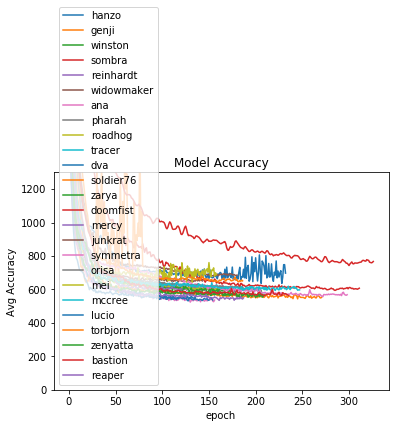

In [8]:
# Run

for hero in specific_stats:
    
    history, model, _ = get_hero_model(hero)
    
    plt.plot(np.sqrt(history.history['val_loss']) * 5000)
    
plt.title('Model Accuracy')
plt.ylabel('Avg Accuracy')
plt.xlabel('epoch')
plt.ylim([0, 1300])
plt.legend(list(specific_stats), loc='lower left')
plt.show()


In [15]:
# Load models from disk

models = {}

for hero in specific_stats:
    
    models[hero] = get_hero_model(hero, from_file=True)


H:\Users\Shriv\Anaconda3\envs\tf-cpu\lib\site-packages\sklearn\base.py:312: UserWarning: Trying to unpickle estimator StandardScaler from version 0.18.2 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [16]:
# Predict using all viable models

def predict_all(player):
    
    sr_predictions = []
    time_played = []

    for hero in specific_stats:
        
        player_hero_stats = player.json['us']['heroes']['stats']['competitive']

        if hero in player_hero_stats and player_hero_stats[hero]['general_stats']['time_played'] >= .2:

            _, model, scaler = models[hero]
                
            sr_predictions.append(predict_sr(model, player, scaler, hero))
            time_played.append(player_hero_stats[hero]['general_stats']['time_played'])
                
    return int(np.average(sr_predictions, weights=time_played))


In [17]:
# Test

with open('test_names.txt', 'r') as test:

    for battletag in find_usernames(test.read()):
        
        player = Player.from_web_battletag(battletag)
        
        actual = get_competitive_rank(player, 'us')
        p = predict_all(player)
        
        print("{} is {}, predicted {}".format(battletag, actual, p))


sshh12#1522 is 2284, predicted 2320
jay#13106 is False, predicted 2351
redpuma200#1798 is 2425, predicted 2359
Panzerjaeger#11644 is 2552, predicted 2326
EXcalibr#1962 is 2223, predicted 2121
WeissCold#1450 is False, predicted 2249
TimN11#1443 is 2221, predicted 2189
Battledik#11416 is 2005, predicted 2321
Tobirama#11276 is 2451, predicted 2280
